In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- data (unchanged) ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
train_dir = "data_classification/augmented/train"
test_dir  = "data_classification/augmented/test"
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
print("class_to_idx:", train_dataset.class_to_idx)
num_classes = len(train_dataset.classes)

# --- Swin backbone (frozen) ---
model = models.swin_b(pretrained=True).to(device)
for p in model.parameters():
    p.requires_grad = False

# feature size before the original head
in_features = model.head.in_features  # 1024 for swin_b
# we won't use the built-in classifier head
model.head = nn.Identity()

def swin_features(net, x):
    # Head is Identity → forward() returns pooled backbone features
    return net(x)   # shape: (N, in_features)  e.g., (N, 1024) for swin_b

# --- trainable projection + center loss ---
proj_dim = 128
feat_proj = nn.Linear(in_features, proj_dim).to(device)

class CenterLoss(nn.Module):
    def __init__(self, num_classes: int, feat_dim: int, device):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim, device=device))
    def forward(self, features: torch.Tensor, labels: torch.Tensor):
        # features: (N, D), labels: (N,) long
        centers_batch = self.centers[labels]
        return ((features - centers_batch) ** 2).sum() / (2.0 * features.size(0))

center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=proj_dim, device=device)

optimizer = optim.Adam([
    {"params": feat_proj.parameters(), "lr": 1e-3},
    {"params": center_loss_fn.parameters(), "lr": 5e-4},  # smaller LR for centers
])

# --- train with center loss only ---
def train_one_epoch():
    model.eval()       # backbone frozen
    feat_proj.train()
    running = 0.0
    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()       # shape (N,)

        with torch.set_grad_enabled(True):
            feats_backbone = swin_features(model, imgs)   # (N, in_features)
            feats = feat_proj(feats_backbone)             # (N, proj_dim)
            loss = center_loss_fn(feats, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * imgs.size(0)
    return running / len(train_loader.dataset)

@torch.no_grad()
def evaluate_epoch():
    model.eval()
    feat_proj.eval()
    correct = total = 0
    total_loss = 0.0
    centers = center_loss_fn.centers  # (C, D)
    for imgs, labels in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        y = labels.to(device, non_blocking=True).long()

        feats = feat_proj(swin_features(model, imgs))
        total_loss += center_loss_fn(feats, y).item() * imgs.size(0)

        # nearest-center classification (L2)
        dists = torch.cdist(feats, center_loss_fn.centers)
        preds = torch.argmin(dists, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return correct / total, total_loss / total


class_to_idx: {'Negative': 0, 'Positive': 1}


/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ai-17/miniconda3/envs/mmdet/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# --- run ---
for epoch in range(10):
    tr_loss = train_one_epoch()
    acc, val_loss = evaluate_epoch()
    print(f"epoch {epoch+1}: train_center {tr_loss:.4f} | val_center {val_loss:.4f} | acc_nc {acc:.3f}")


epoch 1: train_center 24.6671 | val_center 17.7597 | acc_nc 0.779


epoch 2: train_center 15.1344 | val_center 14.4124 | acc_nc 0.797


epoch 3: train_center 12.9784 | val_center 13.2383 | acc_nc 0.820


epoch 4: train_center 11.9729 | val_center 12.3855 | acc_nc 0.820


epoch 5: train_center 11.2571 | val_center 11.8262 | acc_nc 0.829


epoch 6: train_center 10.6938 | val_center 11.5945 | acc_nc 0.820


epoch 7: train_center 10.2125 | val_center 11.0110 | acc_nc 0.839


epoch 8: train_center 9.8595 | val_center 10.4798 | acc_nc 0.839


epoch 9: train_center 9.4173 | val_center 10.1992 | acc_nc 0.834


epoch 10: train_center 9.0335 | val_center 9.9733 | acc_nc 0.839


              precision    recall  f1-score   support

    Negative     0.8547    0.9363    0.8936       157
    Positive     0.7778    0.5833    0.6667        60

    accuracy                         0.8387       217
   macro avg     0.8162    0.7598    0.7801       217
weighted avg     0.8334    0.8387    0.8309       217

Confusion Matrix:
 [[147  10]
 [ 25  35]]


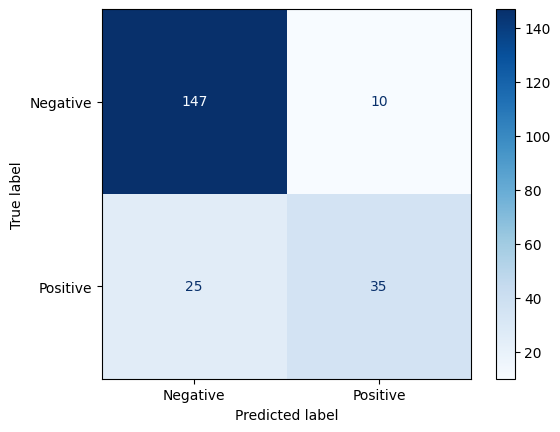

In [7]:
# --- sklearn metrics (nearest-center) ---
@torch.no_grad()
def collect_preds_center():
    model.eval(); feat_proj.eval()
    y_true, y_pred = [], []
    centers = center_loss_fn.centers
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = feat_proj(swin_features(model, imgs))
        dists = torch.cdist(feats, center_loss_fn.centers)
        preds = torch.argmin(dists, dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
    return y_true, y_pred

y_true, y_pred = collect_preds_center()
print(classification_report(y_true, y_pred, target_names=train_dataset.classes, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes).plot(cmap="Blues")
plt.show()